# Script for ECG-based encrypting evaluation

Run this notebook from the base directory.

## Documentation Site

http://wfdb.readthedocs.io/

In [2]:
import math

import wfdb
from wfdb import processing
from sympy import fwht
import matplotlib.pyplot as plt
import os
import shutil
import seaborn as sns
import seaborn.objects as so
import numpy as np

db_name = "ecgiddb/"
#db_name = "ptb-xl/records500/"

# Iterate on all person of dataset
Here we want to compute the inter-distance among all the persons

1.590000000000001

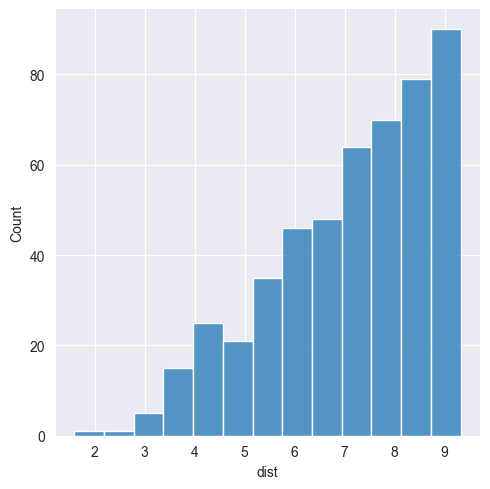

In [2]:
import pandas as pd
list_of_sequences = list()
list_of_person = set()
import statistics

if db_name == "ptb-xl/records500/":
    f = open("ptb-xl/" + "RECORDS", "r")
    for y in f.readlines():
        names = y.split("/")
        if names[0] == "records100":
            continue
        if names[1] == "01000":
            list_of_person.add(names[1] + "/" + names[2].strip())
else:
    f = open(db_name + "RECORDS", "r")
    for y in f.readlines():
        list_of_person.add(y.split("/")[0])
list_of_person = list(list_of_person)
#print(list(list_of_person))
#list_of_person = ['Person_01', 'Person_02', 'Person_03', 'Person_04', 'Person_06']
end_sample=5000
list_of_person_peak = list()
good_person = list()
for person in list_of_person[:100]:
    try:
        if db_name == "ptb-xl/records500/":
            record = wfdb.rdrecord(db_name + person, sampfrom=0, sampto=end_sample, channels=[1])
            good_person.append(person)
        else:
            record = wfdb.rdrecord(db_name + person + "/rec_2", sampfrom=0, sampto=end_sample, channels=[1])
            good_person.append(person)
    except FileNotFoundError:
        #list_of_person.remove(person)
        continue

    # Use the GQRS algorithm to detect QRS locations in the first channel
    qrs_inds = processing.qrs.gqrs_detect(sig=record.p_signal[:,0], fs=record.fs)

    if len(qrs_inds) < 1:
        #list_of_person.remove(person)
        continue
    # Correct the peaks shifting them to local maxima
    min_bpm = 20
    max_bpm = 230
    # min_gap = record.fs * 60 / min_bpm
    # Use the maximum possible bpm as the search radius
    search_radius = int(record.fs * 60 / max_bpm)
    corrected_peak_inds = processing.peaks.correct_peaks(record.p_signal[:,0],
                                                     peak_inds=qrs_inds,
                                                     search_radius=search_radius,
                                                     smooth_window_size=150)
    # Order the peaks index
    corrected_peak_inds = sorted(corrected_peak_inds)
    
    q_values = list()
    for starting_point in corrected_peak_inds:
        prev_value = record.p_signal[starting_point]
        for x in range(starting_point, 0, -1):
            curr_value = record.p_signal[x]
            if curr_value > prev_value: # we are at the bottom
                q_values.append(x + 1)
                break
            prev_value = curr_value

    s_values = list()
    for starting_point in corrected_peak_inds:
        prev_value = record.p_signal[starting_point]
        for x in range(starting_point, end_sample, 1):
            curr_value = record.p_signal[x]
            if curr_value > prev_value: # we are at top
                s_values.append(x -1)
                break
            prev_value = curr_value


    sequences_numpy = list()
    for q, r, s in zip(q_values, corrected_peak_inds, s_values):
        current_seq = record.p_signal[r-20:r+20]
        transform = fwht(current_seq.ravel().tolist())
        if len(transform) < 32:
            continue
        if len(transform) > 1:
            sequences_numpy.append(np.array(transform)[:32])

    try:
        sequences = np.median(sequences_numpy, axis=0)
    except ValueError:
        for u in sequences_numpy:
            print(len(u))
    sequences = sequences.tolist()
    list_of_sequences.append(sequences)

all_dist_dataset = pd.DataFrame(columns=["p1i", "p1","p2i", "p2", "dist"])
for index, y in enumerate(list_of_sequences):
    for index_compare, z in enumerate(list_of_sequences[index+1:]):
        first = np.array(y, dtype=np.float64)
        second = np.array(z, dtype=np.float64)
        dist = np.sum(np.abs(first - second))
        # df = pd.DataFrame({"p1": [index], "p2": [index_compare + index + 1], "dist": [dist]})
        all_dist_dataset.loc[len(all_dist_dataset)] = [index, good_person[index], index_compare + index + 1, good_person[index_compare + index + 1], dist]

#plt.scatter(range(0, len(all_dist_dataset)), all_dist_dataset['dist'])
#plt.ylabel('some numbers')
#plt.show()
ordered = all_dist_dataset.sort_values(by=['dist'])

#plt.plot(list_of_sequences[ordered.iloc[0]['p1i']])
#plt.plot(list_of_sequences[ordered.iloc[0]['p2i']])
#ordered[:10]
#plt.plot(list(ordered['dist']))
sns.displot(ordered[:500], x="dist")
ordered.iloc[0]['dist']


# Iterate on all records of one person
Here we want to compute the intra-distance among all the records of one person

1.0524999999999984

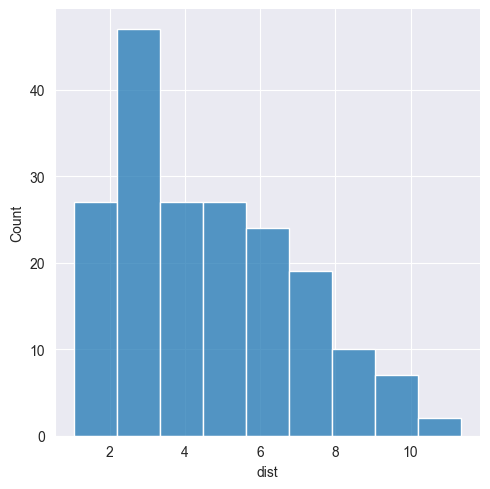

In [3]:

list_of_sequences = list()
f = open(db_name + "RECORDS", "r")
person_name = "Person_01"
list_of_records = set()
for y in f.readlines():
    if y.split("/")[0] != person_name:
        continue
    list_of_records.add(y.split("/")[1].strip())
list_of_records = list(list_of_records)
end_sample=10000
good_record = list()
for person in list_of_records:
    try:
        record = wfdb.rdrecord(db_name + person_name + "/" + person, sampfrom=0, sampto=end_sample, channels=[1])
        good_record.append(person)
    except FileNotFoundError:
        continue

    # Use the GQRS algorithm to detect QRS locations in the first channel
    qrs_inds = processing.qrs.gqrs_detect(sig=record.p_signal[:,0], fs=record.fs)

    if len(qrs_inds) < 1:
        continue
    # Correct the peaks shifting them to local maxima
    min_bpm = 20
    max_bpm = 230
    # min_gap = record.fs * 60 / min_bpm
    # Use the maximum possible bpm as the search radius
    search_radius = int(record.fs * 60 / max_bpm)
    corrected_peak_inds = processing.peaks.correct_peaks(record.p_signal[:,0],
                                                     peak_inds=qrs_inds,
                                                     search_radius=search_radius,
                                                     smooth_window_size=150)

    # Order the peaks index
    corrected_peak_inds = sorted(corrected_peak_inds)

    q_values = list()
    for starting_point in corrected_peak_inds:
        prev_value = record.p_signal[starting_point]
        for x in range(starting_point, 0, -1):
            curr_value = record.p_signal[x]
            if curr_value > prev_value: # we are at the bottom
                q_values.append(x + 1)
                break
            prev_value = curr_value

    s_values = list()
    for starting_point in corrected_peak_inds:
        prev_value = record.p_signal[starting_point]
        for x in range(starting_point, end_sample, 1):
            curr_value = record.p_signal[x]
            if curr_value > prev_value: # we are at top
                s_values.append(x -1)
                break
            prev_value = curr_value


    sequences_numpy = list()
    for q, r, s in zip(q_values, corrected_peak_inds, s_values):
        current_seq = record.p_signal[r-20:r+20]
        transform = fwht(current_seq.ravel().tolist())
        if len(transform) < 32:
            continue
        if len(transform) > 1:
            sequences_numpy.append(np.array(transform)[:32])

    try:
        sequences = np.median(sequences_numpy, axis=0)
    except ValueError:
        for u in sequences_numpy:
            print(len(u))
    sequences = sequences.tolist()
    list_of_sequences.append(sequences)

all_distances = list()
all_dist_dataset_record = pd.DataFrame(columns=["r1", "r2", "dist"])
for index, y in enumerate(list_of_sequences):
    for index_compare, z in enumerate(list_of_sequences[index+1:]):
        first = np.array(y, dtype=np.float64)
        second = np.array(z, dtype=np.float64)
        dist = np.sum(np.abs(first - second))
        all_distances.append(dist)
        #print(list_of_records[index], " ",list_of_records[index_compare + index + 1], dist)
        all_dist_dataset_record.loc[len(all_dist_dataset_record)] = [good_record[index], good_record[index_compare + index + 1], dist]
#plt.scatter(range(0, len(all_distances)), all_distances)
#plt.ylabel('some numbers')
#plt.show()
ordered = all_dist_dataset_record.sort_values(by=['dist'])
ordered[:10]
#plt.plot(list(ordered['dist']))
sns.displot(ordered, x="dist")
ordered.iloc[0]['dist']


### Plot the current ECG, without applying filter
In this part of the code, we consider the first ECG track without applying the filtering

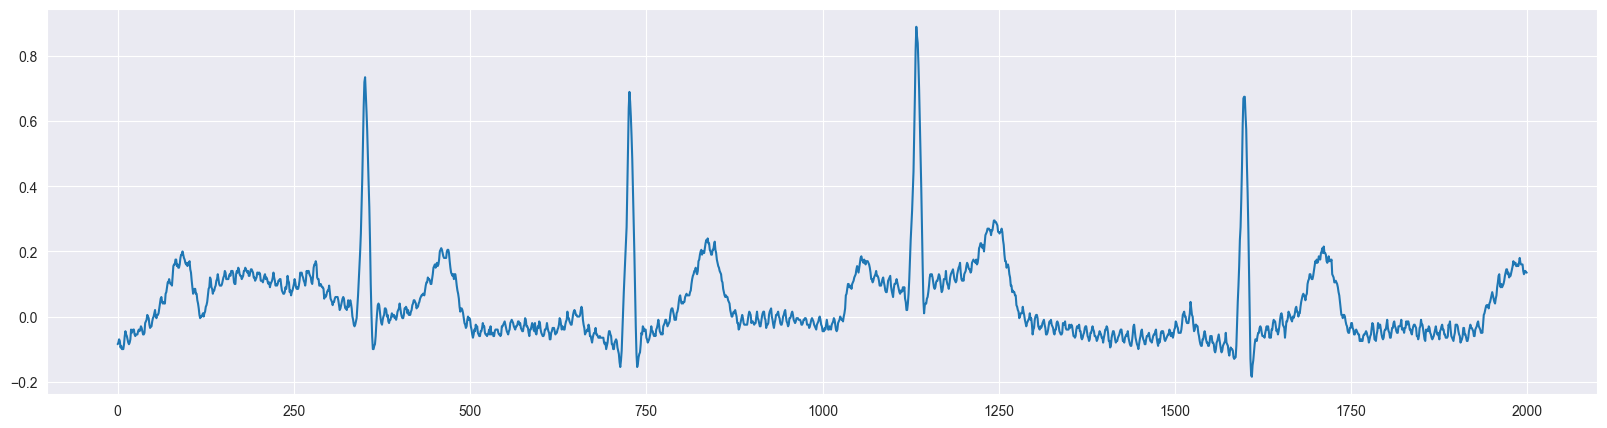

In [21]:
end_sample = 2000
record_comp = wfdb.rdrecord(db_name + 'Person_01' + "/rec_1", sampfrom=0, sampto=end_sample, channels=[0])
# Use the GQRS algorithm to detect QRS locations in the first channel
qrs_inds = processing.qrs.gqrs_detect(sig=record_comp.p_signal[:,0], fs=record.fs)
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(record_comp.p_signal[:,0])

### Apply the filter on ECG in order to produce a signal without interference

In [ ]:
span=math.floor(len(x)/n);
ini=0;
window_length=span;
initial=window_length;

for i=1:1:(floor(length(x))/window_length)
    prev_value_all=0;

    m=1;
    for k=(1+ini):1:(window_length+ini)

        data_all(m,i)=x(k);
        m=m+1;
    end

    %%% data detetrending portion %%%%%

    order_pol=10;
    t=(1:length(data_all(:,i)));

    [p,s,mu]=polyfit(t', data_all(:,i), order_pol);
    f_y=polyval(p,t,[],mu);
    dt_ecgnl=data_all(:,i)-f_y';
    %%%%%%%%%%%%% fresh Data %%%%%%%%%%%

    fresh_data(:,i)=dt_ecgnl;


ini=ini+initial;
end
for x=1:1:n
  re_data(x,:)=[zeros(1,(span*(x-1))) fresh_data(:,x)' zeros(1,(span*(n-x)))];
end
final_data=zeros(1,n*span);
for xx=1:1:n
    final_data=final_data+re_data(xx,:);
end
baseline_out = [final_data];
subplot 211
plot(x)
title('ECG raw signal')
 subplot 212
plot(final_data)
title('Detrend Signal')


In [23]:
import scipy
import mat4py

np.disp(ordered)

x = np.array(ordered['dist']).tolist()

mat4py.savemat('/Users/biagioboi/Desktop/unisa/research/ecg_analysis/ecg_encrypting_analysis/test3.mat', {'dict_diversi': x})

      p1i         p1  p2i         p2      dist
2556   36  Person_02   55  Person_51    1.5900
3655   65  Person_44   81  Person_47    2.2125
1315   16  Person_04   44  Person_40    2.8950
3564   61  Person_16   88  Person_26    2.9950
313     3  Person_45   56  Person_46    3.0750
...   ...        ...  ...        ...       ...
416     4  Person_84   75  Person_31  111.0400
3       0  Person_12    4  Person_84  111.8900
365     4  Person_84   24  Person_41  113.7250
368     4  Person_84   27  Person_17  120.0350
417     4  Person_84   76  Person_30  124.7150

[3916 rows x 5 columns]


254 281
100
[5.36500000000000, -0.0450000000000001, -0.0749999999999997, 0.0150000000000000, -0.155000000000001, -0.00500000000000015, -0.0149999999999998, -0.00500000000000019, 2.02500000000000, 0.195000000000000, 0.365000000000000, -0.165000000000000, 0.885000000000000, -0.465000000000000, -0.955000000000000, -0.0850000000000000, -4.46500000000000, -0.755000000000000, -1.52500000000000, 0.0850000000000000, -3.22500000000000, 0.165000000000000, 0.335000000000000, 0.0650000000000002, -7.54500000000000, 0.385000000000000, 0.735000000000000, 0.125000000000000, 1.51500000000000, 0.285000000000000, 0.575000000000000, -0.0349999999999999, -10.8850000000000, 0.0850000000000000, 0.155000000000000, -0.0150000000000000, 0.315000000000001, 0.0450000000000001, 0.0149999999999998, 0.00500000000000017, -2.20500000000000, -0.335000000000000, -0.705000000000001, 0.225000000000000, -1.70500000000000, 0.565000000000000, 1.17500000000000, 0.145000000000000, 6.16500000000000, 0.775000000000000, 1.5450000

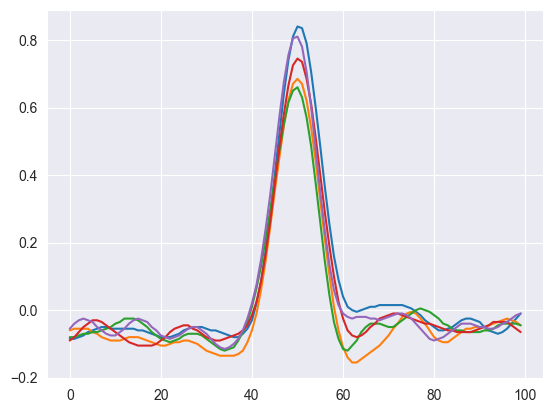

In [11]:
from scipy.linalg import hadamard

hadamard()
for q, r, s in zip(q_values, corrected_peak_inds, s_values):
    print(q, s)
    current_seq = record.p_signal[r-50:r+50]
    plt.plot(current_seq)
    print(len(current_seq))
    transform = fwht(current_seq.ravel().tolist())
    print(transform)

ValueError: n must be an positive integer, and n must be a power of 2